# N-MNIST Example

This tutorial walks you through the different steps involved in building, training and deploying an N-MNIST classification model with a spiking network built with `sinabs`, our software for the simulation of spiking convolutional networks.


## Looking into the dataset

N-MNIST is an event-based version of the popular MNIST dataset, which consists of images of handwritten digits 0-9. In a previous tutorial, we used the `aermanager` library to prepare the recordings and slicing them into frames. Let's load those data and look into them. We're not interested in the whole raster, but only in the 3000-spike frames that we created.

In [11]:
from aermanager.datasets import FramesDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np


dataset_train = FramesDataset(
    "../aermanager/data/N-MNIST/Train/", # depending on where you generated the data
    transform=np.float32, # must turn frame data into floats
    target_transform=int, # string labels are turned into ints
)

dataloader_train = DataLoader(dataset_train, shuffle=True, num_workers=4, batch_size=64)

Label 5
Shape of frame (2, 34, 34)


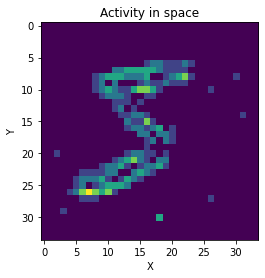

In [18]:
# example frame
frame, label = dataset_train[0]

print("Label", label)
print("Shape of frame", frame.shape)

plt.imshow(frame.sum(axis=0))

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Activity in space");

#  Training an analog `PyTorch` Model

### Model definition
We start by simply defining our model in `PyTorch`. In this example we instantiate a `nn.Sequential` model with 3 `Conv2d` layers and two dense (`nn.Linear`) layers.

In [19]:
import torch.nn as nn

ann = nn.Sequential(
    nn.Conv2d(2, 20, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Conv2d(20, 32, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Conv2d(32, 128, 3, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    nn.Flatten(),
    nn.Linear(128, 500, bias=False),
    nn.ReLU(),
    nn.Linear(500, 10, bias=False),
)

### Training

We start by first training the `ann` over the `MNIST` image dataset. **Note** here that we are not yet using spiking input, these are just images. This is vanilla training for standard image classification.

We iterate over our data loader `train_loader` and train our parameters using the `Adam` optimizer with a learning rate of `1e-3`. Since the last layer in our network has no specific activation function defined, `cross_entropy` loss is a good candidate to train our network.

In [20]:
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim


device = "cuda" if torch.cuda.is_available() else "cpu"
ann = ann.to(device) # GPU
optim = torch.optim.Adam(ann.parameters(), lr=1e-3)


# repeat the whole training a number of times
n_epochs = 1
for n in range(n_epochs):
    
    pbar = tqdm(dataloader_train)
    # Iterate over data
    for data, target in pbar:
        data, target = data.to(device), target.to(device) # GPU
        output = ann(data) # forward pass through the network
        optim.zero_grad()

        # Add loss to the total loss
        loss = F.cross_entropy(output, target)

        # Propagate loss backwards
        loss.backward()

        # Update weights
        optim.step()

        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)

        # Compute the total correct predictions
        correct = pred.eq(target.view_as(pred)).sum().item()

        pbar.set_postfix({"loss": loss.item(), "accuracy": correct/(len(target))})

# Save model parameters
torch.save(ann.state_dict(), "mnist_params300.pt")

### Testing of the ANN

let us first see how the ANN we just trained behaves on the test set. Here, we're still only working with images, composed of spikes accumulated in time, and not with the spike rasters themselves.

In [8]:
dataset_test_frames = FramesDataset(
    "../aermanager/data/N-MNIST/Test/",
    transform=np.float32, # must turn frame data into floats
    target_transform=int, # string labels are turned into ints
)

dataloader_test_frames = DataLoader(dataset_test_frames, shuffle=False, num_workers=4, batch_size=64)

In [9]:
# Iterate over data
acc = []

for data, target in tqdm(dataloader_test_frames):
    data, target = data.to(device), target.to(device)
    output = ann(data)

    # get the index of the max log-probability
    pred = output.argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct = pred.eq(target.view_as(pred)).sum().item() / len(target)
    
    acc.append(correct)

print("Test accuracy (frames, analog network):", sum(acc)/len(acc)*100, '%')


Test accuracy (frames, analog network): 98.03429805871212 %


Training this model on `MNIST` is fairly straight forward and you should reach accuracies of around `>98%` within a small number of epochs (2-3).

# Creating and testing the spiking network

###  Model conversion to SNN

Up until this point we have only operated on images using standard CNN architectures. Now we look at how to build an equivalent spiking convolutional neural network (`SCNN`).

`sinabs` has a handy method for this. Given a standard CNN model, the `from_model` method in `sinabs` that converts it into a spiking neural network. It is a *one liner*! 

In [21]:
from sinabs.from_torch import from_model

input_shape = (2, 34, 34)

sinabs_model = from_model(ann, input_shape=input_shape, add_spiking_output=True)

You can see that this method takes two more parameters in addition to the model to be converted.

`input_shape` is needed in order to instantiate a SNN with the appropriate number of neurons because unline traditional CNNs, SNNs are *stateful*.

`add_spiking_output` is a boolean flag to specify whether or not to add a spiking layer as the last layer in the network. This ensure that both the input and output to our network are of the form of `spikes`.

Let us now look at the generated SCNN. You should see that the only major difference is that the `ReLU` layers are replace by `SpikingLayer`.

In [22]:
sinabs_model.spiking_model

Sequential(
  (0): Conv2d(2, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (1): SpikingLayer()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (4): SpikingLayer()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (7): SpikingLayer()
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=128, out_features=500, bias=False)
  (11): SpikingLayer()
  (12): Linear(in_features=500, out_features=10, bias=False)
  (Spiking output): SpikingLayer()
)

### Model validation in sinabs simulation

Lets test our SCNN model to verify whether the network is infact "equivalent" to the CNN model in terms of its performance. As we did previously we start by defining a data loader (this time is is going to produce spikes) and then pass it to our test method.

In [23]:
from aermanager.datasets import SpikeTrainDataset

dataset_test_spiketrains = SpikeTrainDataset(
    "../aermanager/data/N-MNIST/Test/",
    transform=np.float32, # must turn frame data into floats
    target_transform=int, # string labels are turned into ints
    dt=1000, # time resolution of spikes fed to sinabs: 1000 microseconds
)

dataloader_test_spiketrains = DataLoader(dataset_test_spiketrains, shuffle=True,
                                    num_workers=4, batch_size=1)

The dataset contains arrays of shape (timesteps, channels, x, y):

In [24]:
raster, label = dataset_test_spiketrains[54]

print(label)
print(raster.shape)

4
(21, 2, 34, 34)


In [25]:
raster.sum()

300.0

Since the spiking simulations are significantly slower on a PC, we are going to limit our test to 200 samples here. You can of course test it on the entire 10k samples if you want to verify that it works.

In [26]:
# Iterate over data
acc = []

for data, target in tqdm(dataloader_test_spiketrains):
    sinabs_model.reset_states()
    
    data = data[0].to(device)
    output = sinabs_model(data)
    
    # we sum the number of output spikes in time for each sample
    output = output.sum(axis=0) # (135, 10)

    # get the index of the max log-probability
    pred = output.argmax() # which neuron spikes most

    # Compute the total correct predictions
    correct = pred.item() == target.item()
    
    acc.append(correct)
    
    # let's stop at 200 samples, otherwise it takes too long
    if len(acc) > 200:
        break

print("Test accuracy (spiketrains, spiking network):", sum(acc)/len(acc)*100, '%')


Test accuracy (spiketrains, spiking network): 20.8955223880597 %


We see that this auto-generated spiking (`sinabs_model`) network's performance is much worse than `ann`! Later, it could be explained and fixed in network-optimization.ipynb and network-optimization-weight_rescaling.ipynb .

## See what the network is doing

First, let's look at the **input data** once again:

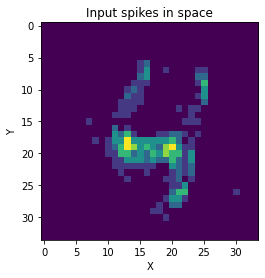

In [27]:
# take one random slice of data
raster, label = dataset_test_spiketrains[54]

# plot it in space: this is the same as the frame,
# we remove the time dimension
plt.title("Input spikes in space")
plt.imshow(raster.sum((0, 1)))
plt.xlabel("X")
plt.ylabel("Y");

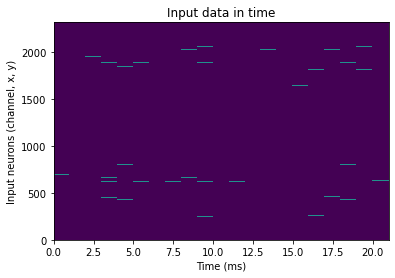

In [28]:
# Let's plot it in time
plt.title("Input data in time")
plt.pcolormesh(raster.reshape((-1, 2*34*34)).T)
plt.xlabel("Time (ms)")
plt.ylabel("Input neurons (channel, x, y)");

Let's now do a forward pass of these data through the network, and then plot the output.

In [29]:
# forward pass
output = sinabs_model(torch.tensor(raster))

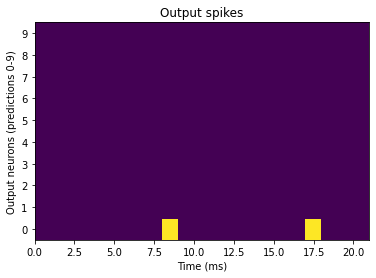

In [33]:
plt.title("Output spikes")

plt.pcolormesh(output.T.detach().numpy())

plt.xlabel("Time (ms)")
plt.ylabel("Output neurons (predictions 0-9)")
plt.yticks(np.arange(10)+0.5, np.arange(10));

The output neuron that spikes the most should be the one corresponding to the digit shown in the input data.